In [1]:
# Credentials for Spotify API
from credentials import client_id, client_secret
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

client_credentials_manager = SpotifyClientCredentials(
    client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [16]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
import time

In [17]:
# fetch techno playlists from spotify 
techno_lists = sp.search(q='techno, rave, future rave', type='playlist', limit=50)
techno_playlists = []
techno_songs = pd.DataFrame(columns=['song_name', 'artist_name', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'like'])


In [18]:
# iterate through playlists and print all playlist names
for i, playlist in enumerate(techno_lists['playlists']['items']):
    print("%4d %s %s" % (i + 1, playlist['uri'], playlist['name']))
    techno_playlists.append(sp.playlist(playlist['uri']))
    
        

   1 spotify:playlist:6MkLRE2XRC1FiEghfzzNme FUTURE RAVE ⚡ David Guetta & MORTEN
   2 spotify:playlist:37i9dQZF1DXdLEN7aqioXM Retrowave // Outrun
   3 spotify:playlist:6X2pHYQ2jqVkuu2X75Irou Future Rave Music
   4 spotify:playlist:37i9dQZF1DWSXMERUaiq9M rave
   5 spotify:playlist:2M12Dv46qTQUpblD2bHIDN Best Rave Drops - Future Rave EDM Hits 2023 | Top Rave Songs, Hard Rave Tracks, Biggest Drops, MDMA Trip Musik, Rave Factory, Rave Time, Rave Best Of
   6 spotify:playlist:37i9dQZF1DX36TRAnIL92N Techno Workout
   7 spotify:playlist:6wveaXND59PWhvnKZEyrID BIG ROOM TECHNO RAVE // FUTURE TECHNO
   8 spotify:playlist:37i9dQZF1DXbjGYBfEmjR5 Future Funk
   9 spotify:playlist:6Dd8oHSE5TPstEXNgZbn9C Future RAVE - David Guetta | Future Rave 2023  |  Future Techno ⚡ Satisfaction - David Guetta
  10 spotify:playlist:37i9dQZF1DX8cbjeZ4UYIG Rave Classics
  11 spotify:playlist:6mwSDs1KfGijGeSyuVzuSz 2000s Techno Classics
  12 spotify:playlist:37i9dQZF1DX8ZMwsPgxIOs Techno State
  13 spotify:playlist:6

In [15]:
len(techno_temp[0]['tracks']['items'])

90

In [19]:
# fetch songs from each of the techno playlists and put into a dataframe
duplicate_counter = 0
request_counter = 0
for i, playlist in enumerate(techno_playlists):
    print("%4d %s %s" % (i + 1, playlist['uri'], playlist['name']))
    tracks = playlist['tracks']['items']
    
    # Gather all track ids from the playlist
    track_ids = []
    for j in range(len(tracks)):
        track = tracks[j]['track']
        # make a guard for NoneType, if none, skip
        if track is None or track['id'] is None:
            # skip
            continue
        track_ids.append(track['id'])

    # Request audio features in batches to avoid rate limit error
    for j in range(0, len(track_ids), 100):  # Spotify API allows up to 100 ids per request
        batch = track_ids[j:j+100]
        
        # if 2 batches have been requested, sleep for 0.4 seconds
        if request_counter % 2 == 0 and request_counter > 0:
            time.sleep(0.4)
        request_counter += 1
        
        # get the audio features for all songs in the batch
        features_list = sp.audio_features(batch)

        for k, features in enumerate(features_list):
            if not features:
                continue
            feature_keys = ['danceability', 'energy', 'key', 'loudness', 'mode', 
                    'speechiness', 'acousticness', 'instrumentalness', 
                    'liveness', 'valence', 'tempo']
            if any(features.get(key) is None for key in feature_keys):
                continue
            # get the song name and artist
            song_name = tracks[j+k]['track']['name']
            artist_name = tracks[j+k]['track']['artists'][0]['name']
            # check if song_name with a specific artist_name already exists in the dataframe
            if not techno_songs[(techno_songs['song_name'] == song_name) & (techno_songs['artist_name'] == artist_name)].empty:
                duplicate_counter += 1
                print("Duplicate song found: %s" % song_name + " by " + artist_name)
            else:
                # get the audio features
                danceability = features['danceability']
                energy = features['energy']
                key = features[ 'key']
                loudness = features['loudness']
                mode = features['mode']
                speechiness = features['speechiness']
                acousticness = features['acousticness']
                instrumentalness = features['instrumentalness']
                liveness = features['liveness']
                valence = features['valence']
                tempo = features['tempo']
                # add the song and the features to the dataframe
                techno_songs.loc[len(techno_songs)] = [song_name, artist_name, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo,1]


   1 spotify:playlist:6MkLRE2XRC1FiEghfzzNme FUTURE RAVE ⚡ David Guetta & MORTEN
   2 spotify:playlist:37i9dQZF1DXdLEN7aqioXM Retrowave // Outrun
   3 spotify:playlist:6X2pHYQ2jqVkuu2X75Irou Future Rave Music
Duplicate song found: On A Roll by Sander van Doorn
Duplicate song found: Lost In The Rhythm by David Guetta
Duplicate song found: Miracle (with Ellie Goulding) - David Guetta Remix by Calvin Harris
Duplicate song found: Satisfaction (Hardwell & Maddix Remix) by David Guetta
Duplicate song found: Juno by David Guetta
   4 spotify:playlist:37i9dQZF1DWSXMERUaiq9M rave
Duplicate song found: Space Train by Kevin D'Angello
   5 spotify:playlist:2M12Dv46qTQUpblD2bHIDN Best Rave Drops - Future Rave EDM Hits 2023 | Top Rave Songs, Hard Rave Tracks, Biggest Drops, MDMA Trip Musik, Rave Factory, Rave Time, Rave Best Of
Duplicate song found: Titanium (feat. Sia) - David Guetta & MORTEN Future Rave Remix by David Guetta
Duplicate song found: I'm Good (Blue) - R3HAB Remix by David Guetta
Dupli

In [21]:
# describe the dataframe
techno_songs.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,like
count,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.0
mean,0.657086,0.840017,5.476238,-6.442726,0.546519,0.091655,0.059916,0.426261,0.210957,0.348281,129.348874,1.0
std,0.124803,0.144555,3.584146,2.932414,0.497915,0.083106,0.129474,0.371923,0.166805,0.242446,14.340178,0.0
min,0.000000,0.039200,0.000000,-28.285000,0.000000,0.000000,0.000002,0.000000,0.021600,0.000000,0.000000,1.0
25%,0.584000,0.784750,2.000000,-7.712000,0.000000,0.044900,0.001897,0.010700,0.096000,0.138000,125.000000,1.0
50%,0.665000,0.884000,6.000000,-5.920000,1.000000,0.060050,0.010200,0.428000,0.139500,0.315000,127.988000,1.0
75%,0.741250,0.942000,8.000000,-4.561750,1.000000,0.099800,0.049675,0.821250,0.303000,0.522000,133.681500,1.0
max,0.973000,1.000000,11.000000,0.599000,1.000000,0.849000,0.977000,0.987000,0.953000,0.970000,202.589000,1.0


In [22]:
print("Number of duplicate songs: %d" % duplicate_counter)
print("Number of songs: %d" % len(techno_songs))
print("Number of batches requested: %d" % request_counter)

Number of duplicate songs: 595
Number of songs: 2988
Number of batches requested: 50


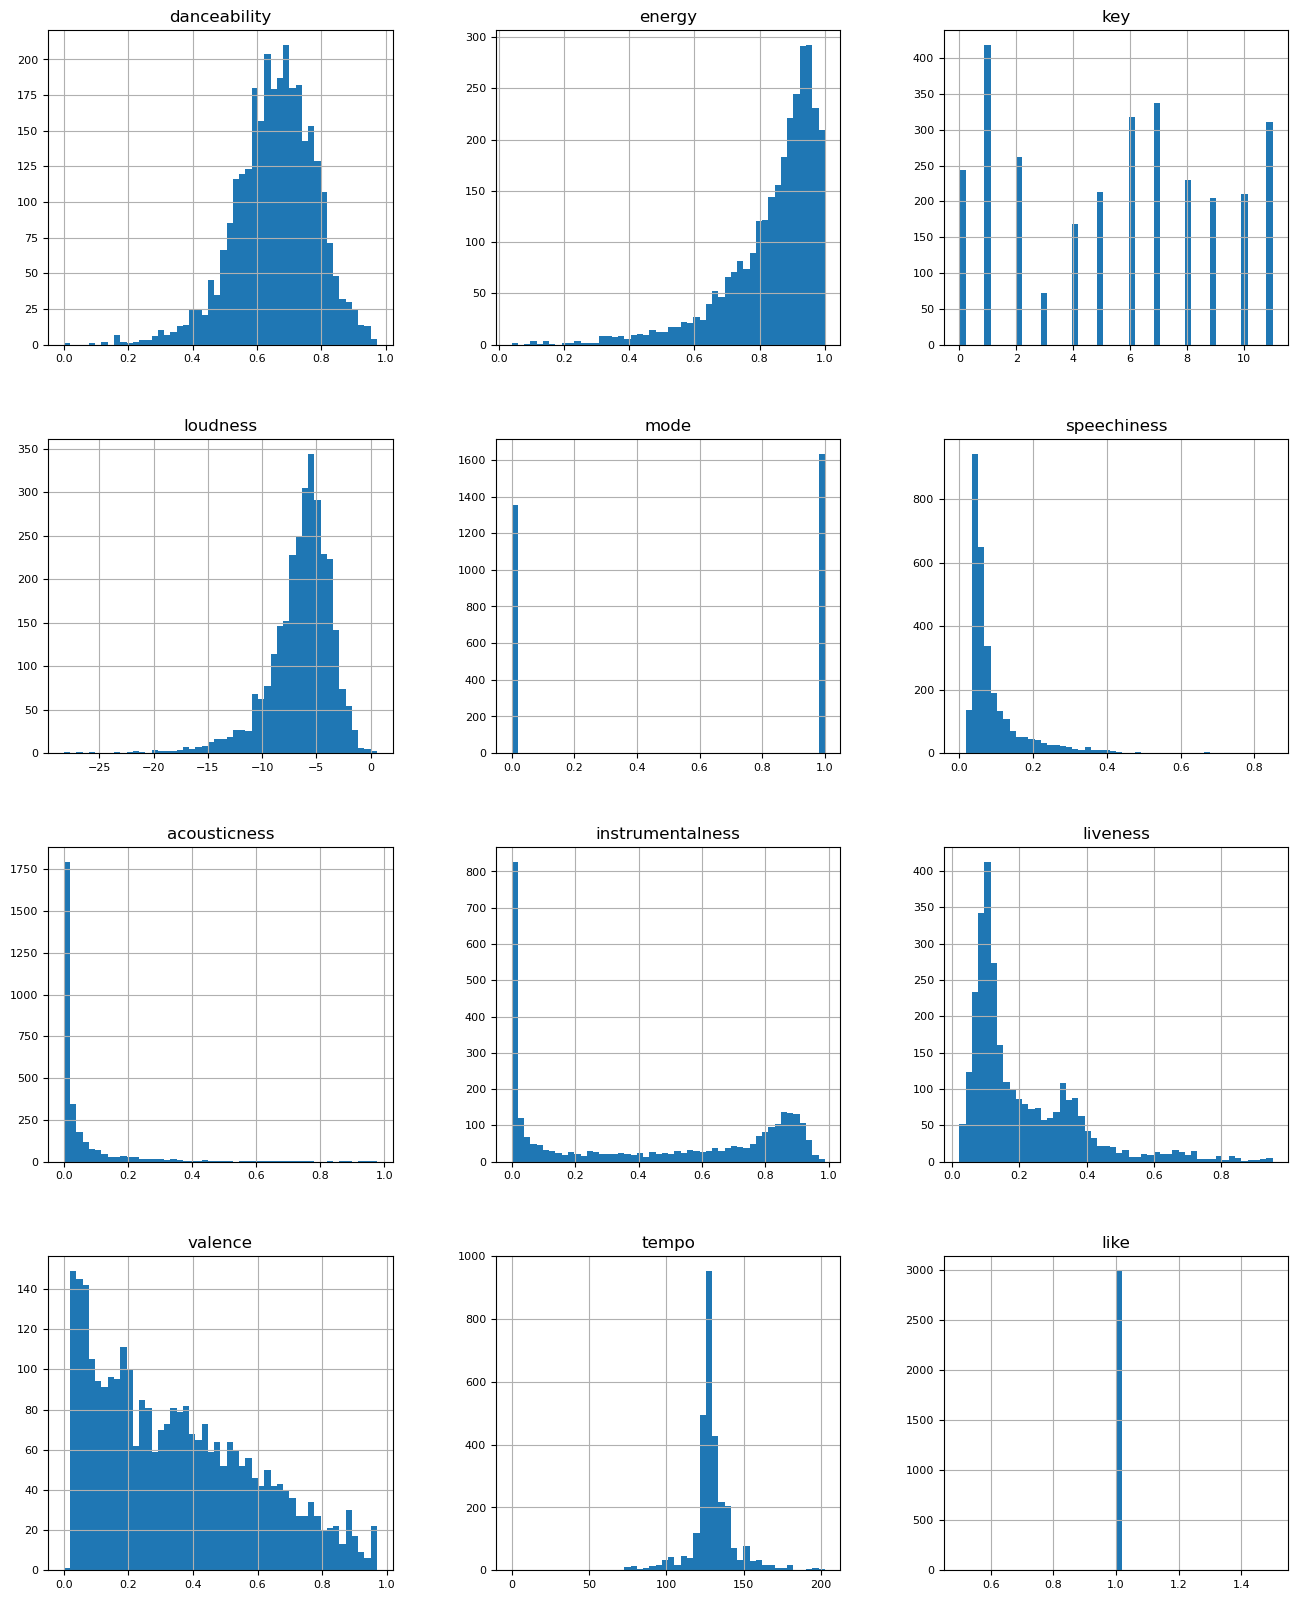

In [23]:
# display the dataframe in a histogram
techno_songs.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);


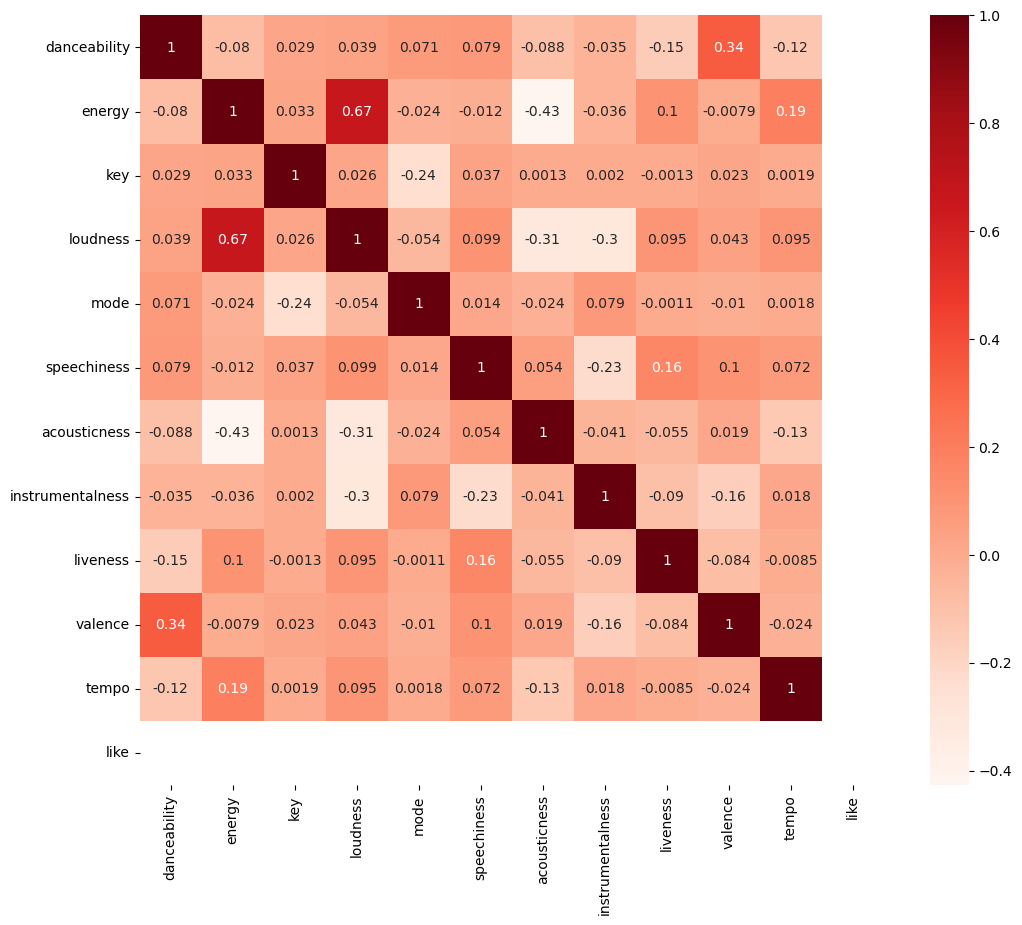

In [24]:
# find the correlation between the features
corr = techno_songs.corr()
corr

# display the correlation in a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()





In [26]:
# based on the techno_songs values, create a new dataframe that has normalized values
techno_songs_norm = techno_songs.copy()
techno_songs_norm[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']] = techno_songs_norm[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
techno_songs_norm.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,like
count,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.0
mean,0.675319,0.833490,0.497840,0.756207,0.546519,0.107956,0.061325,0.431875,0.203303,0.359052,0.638479,1.0
std,0.128266,0.150453,0.325831,0.101524,0.497915,0.097886,0.132522,0.376822,0.179090,0.249945,0.070785,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.600206,0.775968,0.181818,0.712263,0.000000,0.052886,0.001940,0.010841,0.079880,0.142268,0.617013,1.0
50%,0.683453,0.879267,0.545455,0.774304,1.000000,0.070730,0.010438,0.433637,0.126584,0.324742,0.631762,1.0
75%,0.761819,0.939634,0.727273,0.821328,1.000000,0.117550,0.050843,0.832067,0.302126,0.538144,0.659866,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


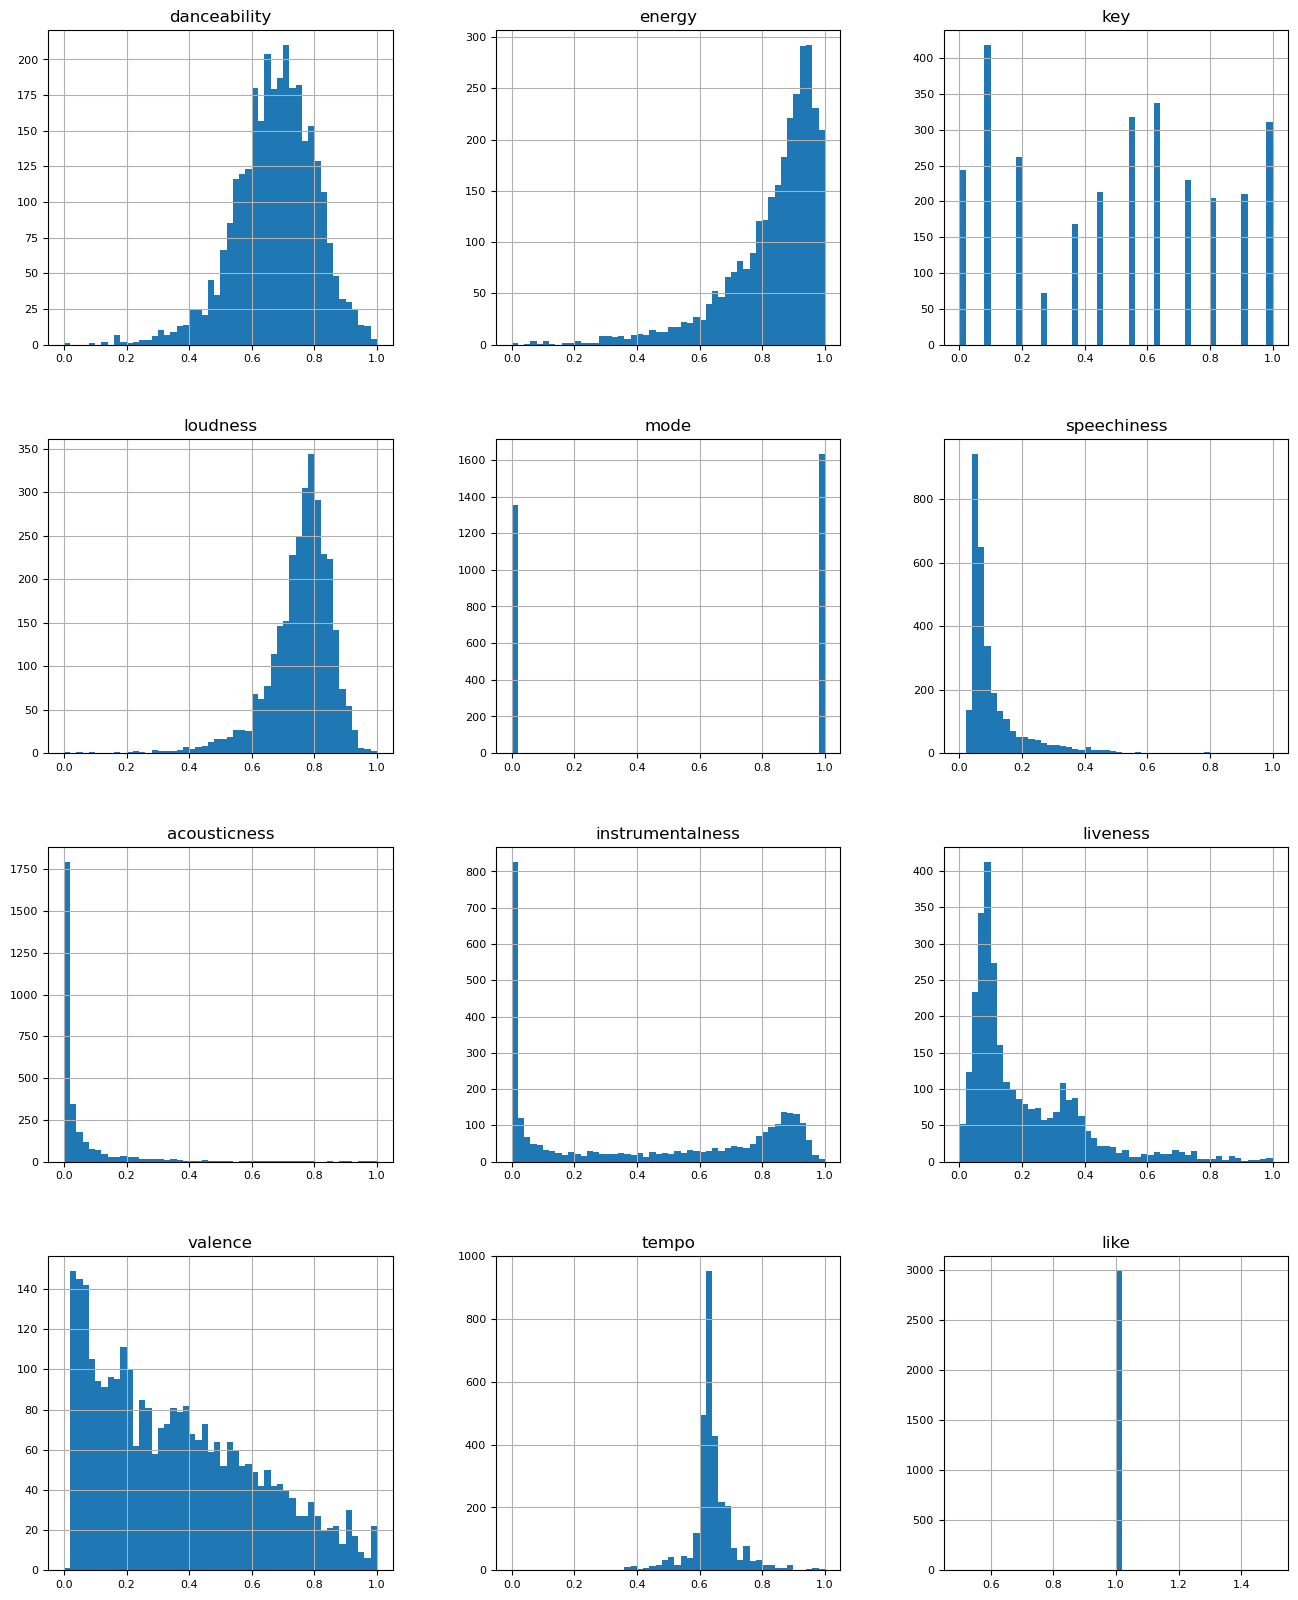

In [27]:
# display the normalized dataframe in a histogram
techno_songs_norm.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);


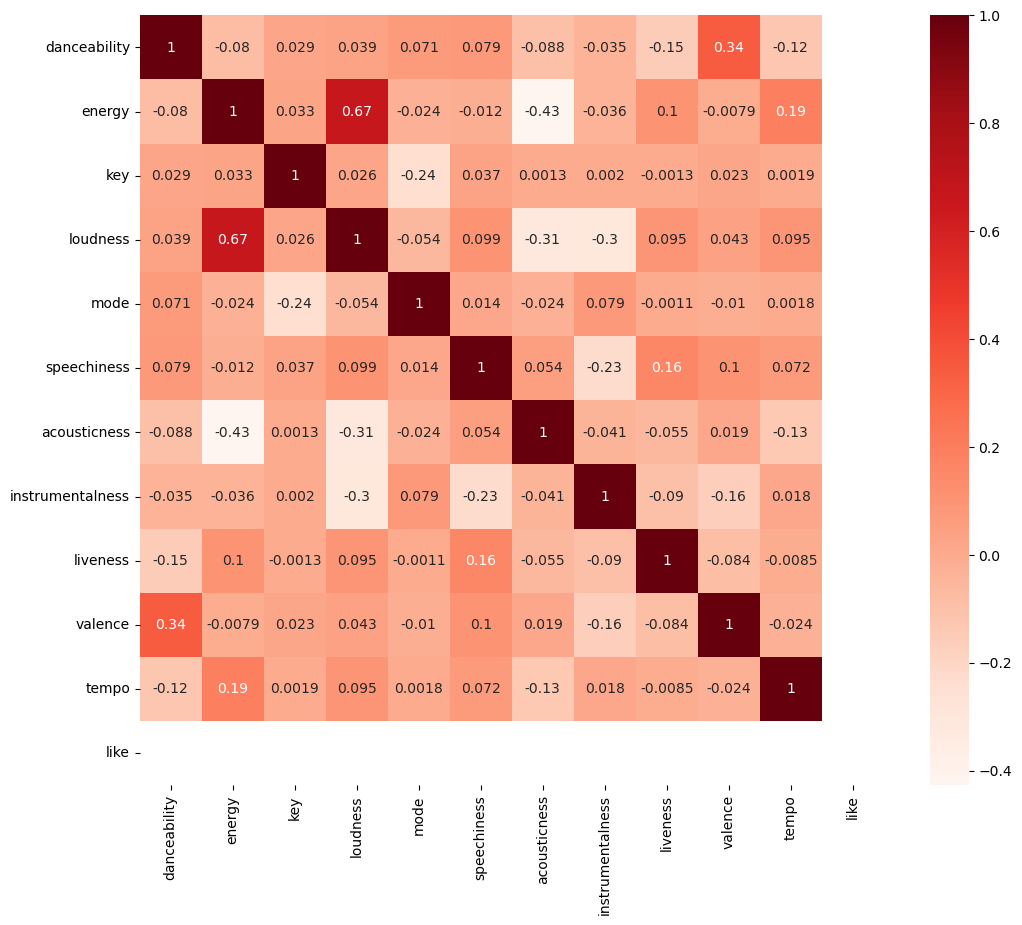

In [29]:
# find the correlation between the normalized features and display in a heatmap
corr_norm = techno_songs_norm.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_norm, annot=True, cmap=plt.cm.Reds)
plt.show()

In [30]:
# remove the upper triangle of the correlation matrix
upper_norm = corr_norm.where(np.triu(np.ones(corr_norm.shape), k=1).astype(np.bool))

# only find the top 4 feature pairs that have the highest correlation
strong_corr_norm = upper_norm.stack().sort_values(ascending=False).iloc[0:4]
strong_corr_norm

C:\Users\USER\AppData\Local\Temp\ipykernel_10984\824417113.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_norm = corr_norm.where(np.triu(np.ones(corr_norm.shape), k=1).astype(np.bool))


energy        loudness    0.665852
danceability  valence     0.344650
energy        tempo       0.189711
speechiness   liveness    0.156306
dtype: float64

In [25]:
# remove the upper triangle of the correlation matrix 
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))


# only find the top 4 feature pairs that have the highest correlation
strong_corr = upper.stack().sort_values(ascending=False).iloc[0:4]
strong_corr

C:\Users\USER\AppData\Local\Temp\ipykernel_10984\1889419626.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))


energy        loudness    0.665852
danceability  valence     0.344650
energy        tempo       0.189711
speechiness   liveness    0.156306
dtype: float64

<AxesSubplot:>

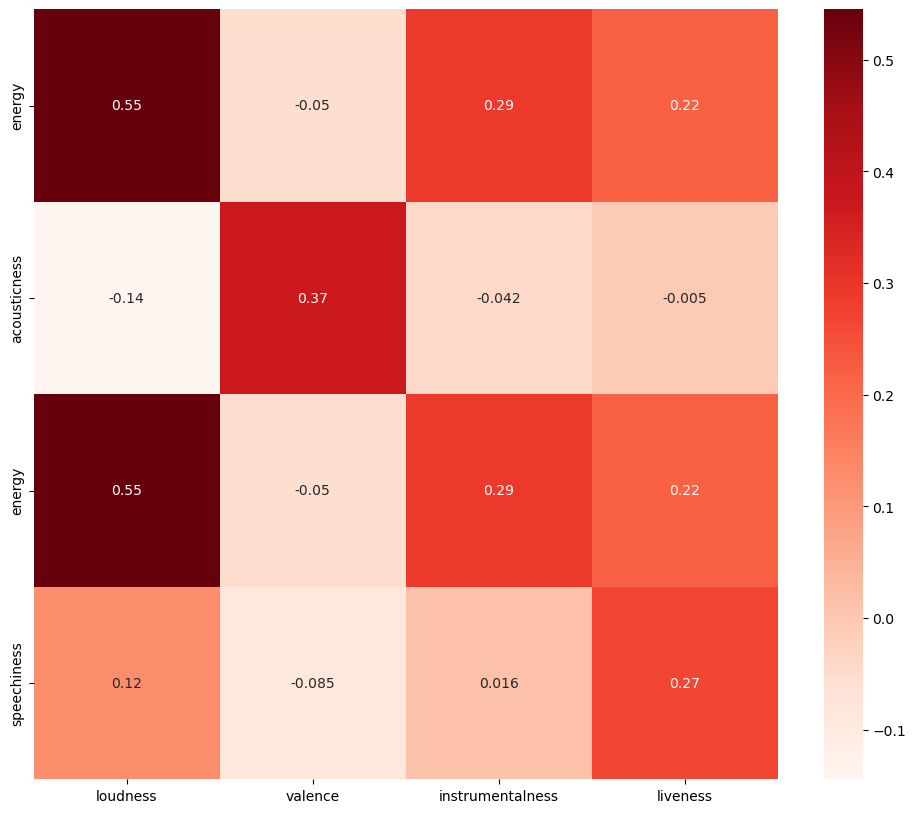

In [12]:
# top 4 feature pairs that have the highest correlation are danceability and energy, danceability and valence, energy and valence, and loudness and energy
# show the heatmap of the top 4 feature pairs that have the highest correlation on each own
plt.figure(figsize=(12, 10))
sns.heatmap(corr.loc[['energy', 'acousticness', 'energy',  'speechiness'], ['loudness','valence', 'instrumentalness', 'liveness']], annot=True, cmap=plt.cm.Reds)


                  

In [13]:
# find the max and min value of each feature and display it in a table
party_songs_df.describe().loc[['min', 'max']]





,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
min,0.295,0.486,0.0,-10.966,0.0,0.0289,0.000187,0.000,0.0417,0.0378,90.101
max,0.911,0.990,11.0,-1.810,1.0,0.3400,0.423000,0.915,0.9560,0.9060,183.760


In [14]:
# add a new column called 'like' to the data frame and set all the values to 1
party_songs_df['like'] = 1
party_songs_df



,song_name,artist_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,like
0,Miracle (with Ellie Goulding) - Hardwell Remix,Calvin Harris,0.573,0.763,9,-10.011,1,0.0607,0.00142,0.060900,0.0935,0.197,138.005,1
1,"Alone, Pt. II - Da Tweekaz Remix",Alan Walker,0.555,0.910,3,-3.653,0,0.0628,0.13700,0.000000,0.3350,0.550,154.932,1
2,Astronomia,Vicetone,0.653,0.945,5,-2.634,1,0.0960,0.00561,0.915000,0.4390,0.325,126.093,1
3,Because The Night,Dimitri Vegas & Like Mike,0.387,0.906,11,-5.353,0,0.0781,0.04630,0.000051,0.3980,0.334,143.039,1
4,Dance Tonight,Timmy Trumpet,0.506,0.880,4,-4.711,0,0.0965,0.01150,0.000000,0.0719,0.361,159.871,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Can't Go Home (feat. Adam Lambert) - Crystal L...,Steve Aoki,0.534,0.767,9,-4.807,0,0.3050,0.01650,0.000000,0.1880,0.225,127.992,1
96,Primer,DubVision,0.681,0.864,4,-2.951,0,0.0490,0.02600,0.000563,0.5860,0.249,127.994,1
97,Haartz,KAAZE,0.474,0.882,2,-4.249,1,0.0957,0.01570,0.013800,0.6080,0.190,129.990,1
98,All To Myself,Nolan van Lith,0.455,0.562,2,-5.031,1,0.0293,0.00504,0.000000,0.3650,0.282,128.042,1


In [15]:
# add songs from another playlist to the dataframe
# get the playlist with this user id 1mTq4kJyaErdNqIXNb2OFG
#  the like column is set to 0 because these songs are not liked by the user
chill_songs = sp.playlist('1mTq4kJyaErdNqIXNb2OFG')
for i in range(len(chill_songs['tracks']['items'])):
    # get the audio features for all the songs in the playlist
    features = sp.audio_features(chill_songs['tracks']['items'][i]['track']['id'])
    # get the song name
    song_name = chill_songs['tracks']['items'][i]['track']['name']
    # get the artist name
    artist_name = chill_songs['tracks']['items'][i]['track']['artists'][0]['name']
    # get the audio features
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    key = features[0][ 'key']
    loudness = features[0]['loudness']
    mode = features[0]['mode']
    speechiness = features[0]['speechiness']
    acousticness = features[0]['acousticness']
    instrumentalness = features[0]['instrumentalness']
    liveness = features[0]['liveness']
    valence = features[0]['valence']
    tempo = features[0]['tempo']
    # add the song and the features to the dataframe
    party_songs_df.loc[len(party_songs_df)] = [song_name, artist_name, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, 0]

In [16]:
party_songs_df

,song_name,artist_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,like
0,Miracle (with Ellie Goulding) - Hardwell Remix,Calvin Harris,0.573,0.763,9,-10.011,1,0.0607,0.00142,0.060900,0.0935,0.197,138.005,1
1,"Alone, Pt. II - Da Tweekaz Remix",Alan Walker,0.555,0.910,3,-3.653,0,0.0628,0.13700,0.000000,0.3350,0.550,154.932,1
2,Astronomia,Vicetone,0.653,0.945,5,-2.634,1,0.0960,0.00561,0.915000,0.4390,0.325,126.093,1
3,Because The Night,Dimitri Vegas & Like Mike,0.387,0.906,11,-5.353,0,0.0781,0.04630,0.000051,0.3980,0.334,143.039,1
4,Dance Tonight,Timmy Trumpet,0.506,0.880,4,-4.711,0,0.0965,0.01150,0.000000,0.0719,0.361,159.871,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,Best Friend,Rex Orange County,0.575,0.714,6,-5.247,1,0.0596,0.39500,0.000000,0.1150,0.320,144.982,0
134,Sunflower,Rex Orange County,0.384,0.765,6,-4.463,1,0.0579,0.64600,0.003520,0.5220,0.567,129.903,0
135,Happiness,Rex Orange County,0.399,0.235,5,-9.774,1,0.0334,0.73400,0.000002,0.1610,0.197,105.645,0
136,You've Got a Friend in Me,Rex Orange County,0.788,0.450,3,-7.148,1,0.0278,0.89700,0.000031,0.3000,0.448,113.107,0


In [17]:
party_songs_df.dtypes


song_name            object
artist_name          object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
like                  int64
dtype: object

In [18]:
X_train, y_train = party_songs_df.iloc[:, 2:13], party_songs_df.iloc[:, 13]
X_train, y_train

(     danceability  energy  key  loudness  mode  speechiness  acousticness  \
 0           0.573   0.763    9   -10.011     1       0.0607       0.00142   
 1           0.555   0.910    3    -3.653     0       0.0628       0.13700   
 2           0.653   0.945    5    -2.634     1       0.0960       0.00561   
 3           0.387   0.906   11    -5.353     0       0.0781       0.04630   
 4           0.506   0.880    4    -4.711     0       0.0965       0.01150   
 ..            ...     ...  ...       ...   ...          ...           ...   
 133         0.575   0.714    6    -5.247     1       0.0596       0.39500   
 134         0.384   0.765    6    -4.463     1       0.0579       0.64600   
 135         0.399   0.235    5    -9.774     1       0.0334       0.73400   
 136         0.788   0.450    3    -7.148     1       0.0278       0.89700   
 137         0.607   0.478    1    -5.702     0       0.0310       0.64900   
 
      instrumentalness  liveness  valence    tempo  
 0       

In [19]:
all_songs_df = pd.DataFrame(columns=['song_name', 'artist_name', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'like'])
all_songs_df
# fetch a playlist with this user id 5xS3Gi0fA3Uo6RScucyct6, 37i9dQZF1DX17GkScaAekA
old_party_songs = sp.playlist('5xS3Gi0fA3Uo6RScucyct6')
for i in range(len(old_party_songs['tracks']['items'])):
    # get the audio features for all the songs in the playlist
    features = sp.audio_features(old_party_songs['tracks']['items'][i]['track']['id'])
    # get the song name
    song_name = old_party_songs['tracks']['items'][i]['track']['name']
    # get the artist name
    artist_name = old_party_songs['tracks']['items'][i]['track']['artists'][0]['name']
    # get the audio features
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    key = features[0][ 'key']
    loudness = features[0]['loudness']
    mode = features[0]['mode']
    speechiness = features[0]['speechiness']
    acousticness = features[0]['acousticness']
    instrumentalness = features[0]['instrumentalness']
    liveness = features[0]['liveness']
    valence = features[0]['valence']
    tempo = features[0]['tempo']
    # add the song and the features to the dataframe
    all_songs_df.loc[len(all_songs_df)] = [song_name, artist_name, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo,1]

all_songs_df

,song_name,artist_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,like
0,Like A G6,Far East Movement,0.431,0.862,7,-7.005,0,0.4280,0.00618,0.000000,0.3220,0.696,124.930,1
1,Shots,LMFAO,0.825,0.856,1,-1.912,1,0.0476,0.00851,0.000001,0.1270,0.207,128.016,1
2,Starships,Nicki Minaj,0.747,0.716,11,-2.457,0,0.0750,0.13500,0.000000,0.2510,0.751,125.008,1
3,Good Feeling,Flo Rida,0.706,0.890,1,-4.444,0,0.0688,0.05880,0.002860,0.3060,0.684,128.011,1
4,Fireball (feat. John Ryan),Pitbull,0.761,0.933,10,-5.380,1,0.0560,0.09080,0.000085,0.0607,0.836,122.959,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Bumpy Ride,Mohombi,0.706,0.842,0,-4.628,0,0.0380,0.04760,0.000000,0.1340,0.818,104.958,1
96,Walking on Sunshine,CARSTN,0.727,0.899,10,-4.962,1,0.0384,0.08520,0.000000,0.5080,0.634,114.979,1
97,Teenage Dream,Katy Perry,0.719,0.804,10,-4.581,1,0.0355,0.01320,0.000003,0.1390,0.605,119.999,1
98,"Young, Wild & Free (feat. Bruno Mars)",Snoop Dogg,0.715,0.655,0,-6.425,1,0.1370,0.05250,0.000000,0.1150,0.531,95.078,1


In [20]:
classical_songs = sp.playlist('37i9dQZF1DX17GkScaAekA')
for i in range(len(classical_songs['tracks']['items'])):
    # get the audio features for all the songs in the playlist
    features = sp.audio_features(classical_songs['tracks']['items'][i]['track']['id'])
    # get the song name
    song_name = classical_songs['tracks']['items'][i]['track']['name']
    # get the artist name
    artist_name = classical_songs['tracks']['items'][i]['track']['artists'][0]['name']
    # get the audio features
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    key = features[0][ 'key']
    loudness = features[0]['loudness']
    mode = features[0]['mode']
    speechiness = features[0]['speechiness']
    acousticness = features[0]['acousticness']
    instrumentalness = features[0]['instrumentalness']
    liveness = features[0]['liveness']
    valence = features[0]['valence']
    tempo = features[0]['tempo']
    # add the song and the features to the dataframe
    all_songs_df.loc[len(all_songs_df)] = [song_name, artist_name, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo,0]

all_songs_df

,song_name,artist_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,like
0,Like A G6,Far East Movement,0.4310,0.86200,7,-7.005,0,0.4280,0.00618,0.000000,0.3220,0.6960,124.930,1
1,Shots,LMFAO,0.8250,0.85600,1,-1.912,1,0.0476,0.00851,0.000001,0.1270,0.2070,128.016,1
2,Starships,Nicki Minaj,0.7470,0.71600,11,-2.457,0,0.0750,0.13500,0.000000,0.2510,0.7510,125.008,1
3,Good Feeling,Flo Rida,0.7060,0.89000,1,-4.444,0,0.0688,0.05880,0.002860,0.3060,0.6840,128.011,1
4,Fireball (feat. John Ryan),Pitbull,0.7610,0.93300,10,-5.380,1,0.0560,0.09080,0.000085,0.0607,0.8360,122.959,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,"Music for a While (from Oedipus, Z. 583)",Henry Purcell,0.2260,0.00987,9,-23.146,0,0.0354,0.98200,0.902000,0.0742,0.2310,76.365,0
156,Reminiscence,Ólafur Arnalds,0.1830,0.13100,1,-17.785,0,0.0401,0.78500,0.899000,0.1210,0.0543,111.851,0
157,Mahler / Transcr. Tharaud: Symphony No. 5 in C...,Gustav Mahler,0.3420,0.04230,5,-19.428,1,0.0403,0.99000,0.889000,0.1390,0.0391,71.330,0
158,Montero: Adagio (After Bach's Violin Concerto ...,Johann Sebastian Bach,0.3600,0.00301,6,-35.441,0,0.0444,0.99400,0.897000,0.0557,0.1800,72.892,0


In [21]:
X_test, y_test = all_songs_df.iloc[:, 2:13], all_songs_df.iloc[:, 13]

Text(0.5, 0, 'Number of Neighbors')

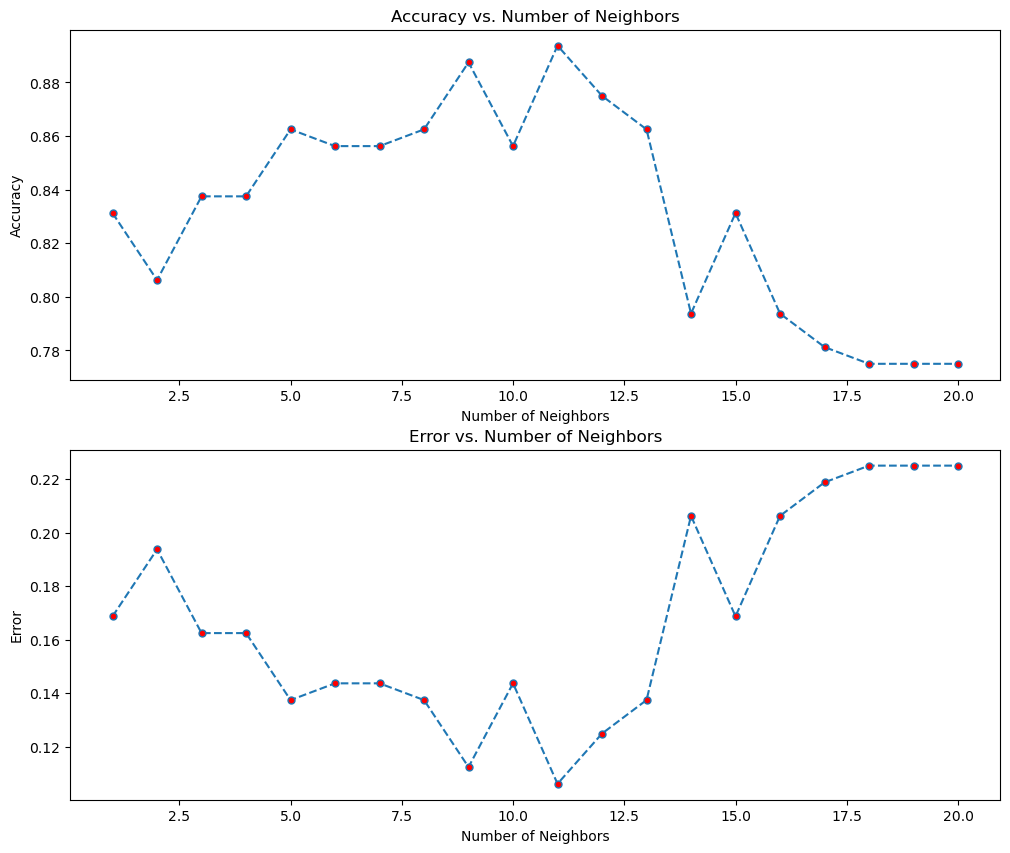

In [22]:
fig, axes = plt.subplots(6, 3, figsize=(12, 10))
neighbors = np.arange(1, 21, 1)
accuracy = list()
error = list()

for n in neighbors:
  knn = KNeighborsClassifier(n_neighbors=n)
  knn.fit(X_train, y_train)
  accuracy.append(knn.score(X_test, y_test))
  error.append(np.mean(y_test != knn.predict(X_test)))

plt.subplot(2, 1, 1)
plt.plot(neighbors, accuracy, linestyle='dashed', marker='o', markerfacecolor='red', markersize=5)
plt.title('Accuracy vs. Number of Neighbors')
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors')

plt.subplot(2, 1, 2)
plt.plot(neighbors, error, linestyle='dashed', marker='o', markerfacecolor='red', markersize=5)
plt.title('Error vs. Number of Neighbors')
plt.ylabel('Error')
plt.xlabel('Number of Neighbors')